A quick demo showing how MixDenoise works: we'll construct an
artificial GMM with 2 components and construct a MixDenoise
layer with 3 components.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import the usual suspects:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from mixdenoise import MixDenoise, mdn_loss, regularized_mdn_loss

import numpy as np
from tqdm import tqdm, tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

- - - 

First, let's construct a function that samples from a Gaussian Mixture Model that will be unknown to our `MixDenoise` model.

In [3]:
### GMM sampling:
gmm_mixes = torch.Tensor([0.5, 0.5 ])
gmm_means = torch.Tensor([ 1.0, 2.0 ])
gmm_stdvs = torch.Tensor([ 0.1, 0.3 ])
def sample_from_gmm(size=1):
    """
    Return a batch of samples from above gaussian components.
    Output shape is (batch_size, 1).
    """
    # draw an integer vector of gaussian component choices:
    choices = torch.multinomial(gmm_mixes, size, replacement=True)
    # get corresponding gaussian samples:
    samples = torch.normal(gmm_means[choices], gmm_stdvs[choices])
    return (choices, samples)

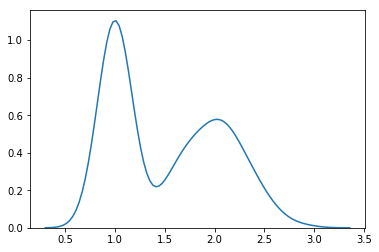

In [4]:
_choices, samples = sample_from_gmm(size=1000)
sns.kdeplot(samples.numpy())

- - -

Now, let's construct our `MixDenoise` model:

In [5]:
### MixDenoise model with 10 mixtures:
mdl = MixDenoise(3, jitter=0.5)
# warm-up the internal means:
mdl.means = nn.Parameter(torch.Tensor([0.0, 1.0, 2.0]), requires_grad=True)

`MixDenoise` exposes the following methods:
* `gmm()`: returns a 3-tuple of torch float variables `(pi, mu, sigma)` each of shape `(num_components,)`, representing the underlying mixture model.
* `sample(size=1)`: return `size` samples from the underlying GMM of the `MixDenoise` model.
* `activations(x)`: given `x ~ (batch_size,)`, return `activs ~ (batch_size, num_components)` giving the probability of each element of `x` against each component gaussian in the GMM.
* `forward(x)`: return the probability of sample `x ~ (batch_size,)` according to the underlying GMM density.

In [6]:
# Quick demo of sampling:
pi, mu, sigma = mdl.gmm()
print(pi)
print("-" * 40)
print(mu)
print("-" * 40)
print(sigma)

Variable containing:
 0.5467
 0.2563
 0.1970
[torch.FloatTensor of size 3]

----------------------------------------
Parameter containing:
 0
 1
 2
[torch.FloatTensor of size 3]

----------------------------------------
Variable containing:
 2.5810
 4.2546
 1.8422
[torch.FloatTensor of size 3]



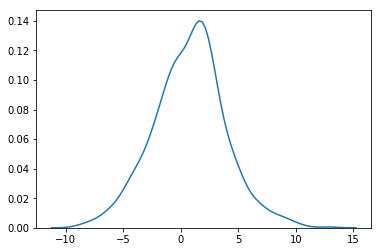

In [7]:
_, mdl_samples = mdl.sample(size=1000)
sns.kdeplot(mdl_samples.data.numpy())

- - -

Finally, let's train our model on the generated GMM samples:

In [8]:
# nb.: choosing a sufficiently small learning rate is important
opt = optim.Adam(mdl.parameters(), lr=0.00001)
def train(regularized=False):
    NUM_ITERS = 1000000
    PRINT_EVERY = 10000
    BSZ = 32
    for k in range(NUM_ITERS):
        # clear gradients:
        opt.zero_grad()
        # generate a sample:
        _, samps = sample_from_gmm(size=BSZ)
        x = Variable(samps)
        # compute loss:
        if not regularized:
            loss = mdn_loss(mdl(x))
        else:
            loss = regularized_mdn_loss(mdl, x)
        # backwards:
        loss.backward()
        opt.step()
        # print:
        if (k % PRINT_EVERY == 0): tqdm.write("{0} | {1}".format(k,loss.data[0]))

    # print weights:
    mdl_pi, mdl_mu, mdl_sigma = mdl.gmm()
    print("*** Learned weights:")
    print(mdl_pi.data)
    print("*** Learned means:")
    print(mdl_mu.data)
    print("*** Learned Stdvs:")
    print(mdl_sigma.data)

In [9]:
train()

0 | 1.9987767934799194
10000 | 1.8879621028900146
20000 | 1.781490683555603
30000 | 1.6685130596160889
40000 | 1.5451526641845703
50000 | 1.446631669998169
60000 | 1.3311938047409058
70000 | 1.2455633878707886
80000 | 1.0814131498336792
90000 | 1.1062030792236328
100000 | 0.9999379515647888
110000 | 0.8833749890327454
120000 | 1.0275815725326538
130000 | 0.8746631145477295
140000 | 0.897672176361084
150000 | 0.820691704750061
160000 | 0.8010134696960449
170000 | 0.7925342917442322
180000 | 0.835989236831665
190000 | 0.7937666773796082
200000 | 0.7695156931877136
210000 | 0.7574431300163269
220000 | 0.7194257378578186
230000 | 0.9468278884887695
240000 | 0.7629249691963196
250000 | 0.8991546034812927
260000 | 0.8057562112808228
270000 | 0.7147462964057922
280000 | 0.8323847651481628
290000 | 0.7216814756393433
300000 | 0.7397158741950989
310000 | 0.8060505986213684
320000 | 0.5188150405883789
330000 | 0.5396626591682434
340000 | 0.504619300365448
350000 | 0.6412566900253296
360000 | 0.4

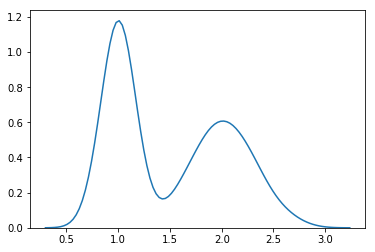

In [10]:
_, mdl_samples = mdl.sample(size=1000)
sns.kdeplot(mdl_samples.data.numpy())

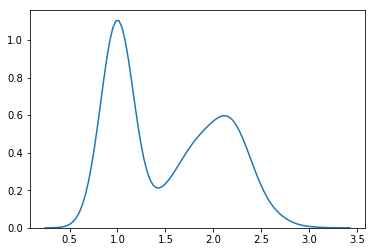

In [11]:
_choices, samples = sample_from_gmm(size=1000)
sns.kdeplot(samples.numpy())

- - - 

Now let's compare this with scikit-learn's Expectation-Maximization and Variational Bayes algorithms for gaussian mixture models.

In [12]:
from sklearn import mixture

First try _GaussianMixture_ with _Expectation-Maximization_:

In [14]:
gmm_em = mixture.GaussianMixture(n_components=3, covariance_type='full', max_iter=100)
for k in range(10000):
    _, samples = sample_from_gmm(size=32)
    gmm_em.fit(samples.numpy().reshape(-1,1))

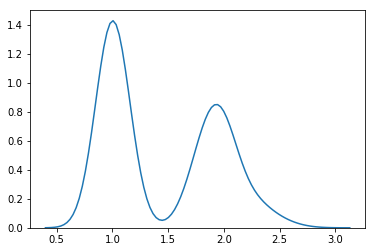

In [22]:
# plot the results:
sns.kdeplot(gmm_em.sample(n_samples=1000)[0][:,0])

And now the _BayesianGaussianMixture_:

In [24]:
gmm_vb = mixture.BayesianGaussianMixture(n_components=3, covariance_type='full', max_iter=1000000)
_, samples = sample_from_gmm(size=1000000)
gmm_vb.fit(samples.numpy().reshape(-1,1))

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=1000000, mean_precision_prior=None, mean_prior=None,
            n_components=3, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

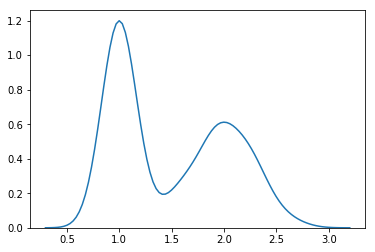

In [25]:
# plot the results:
sns.kdeplot(gmm_vb.sample(n_samples=1000)[0][:,0])